<a href="https://colab.research.google.com/github/charlie-may86/Book-Model/blob/master/book_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to think about the problem:
Say I want to recommed only books which I think my users will rate as a 4 or 5?
- 4-5 can be true
- < 4 can be false  

I have created a classification problem. 

[Data source can be find here](https://www.kaggle.com/zygmunt/goodbooks-10k?select=ratings.csv)

In [2]:
import io
from google.colab import files
import pandas as pd
import numpy as np

In [3]:
#upload books df
upload = files.upload()

Saving books_unit2_project.csv to books_unit2_project (3).csv


In [4]:
#read in books df
books = pd.read_csv(io.BytesIO(upload['books_unit2_project.csv']), delimiter=',')

In [5]:
#upload ratings df
upload = files.upload()

Saving ratings_unit2_project.csv to ratings_unit2_project (2).csv


In [6]:
#read in ratings df
ratings = pd.read_csv(io.BytesIO(upload['ratings_unit2_project.csv']), delimiter=',')

In [7]:
#create a df that contains user_id and their mean rating
average_ratings = pd.DataFrame(ratings.groupby('user_id')['rating'].mean())

#rename the column in average_ratings so it can be added as a separte column back to ratings
average_ratings.rename(columns={"rating": "average_user_rating"}, inplace=True)
average_ratings

#merge ratings and average_ratings to add in a users average rating
ratings_merged = ratings.merge(average_ratings, left_on='user_id', right_on='user_id')


In [8]:
#check
ratings_merged.head()

,book_id,user_id,rating,average_user_rating
0,1,314,5,3.585635
1,3,314,3,3.585635
2,5,314,4,3.585635
3,6,314,5,3.585635
4,12,314,4,3.585635


In [53]:
#merge ratings df and books df 
df_merged = ratings_merged.merge(books, left_on='book_id', right_on='book_id')
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,314,5,3.585635,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,439,3,3.259887,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,588,5,3.618280,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,1169,4,3.770053,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,1185,4,3.473684,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [54]:
df_merged.shape

(79701, 26)

In [55]:
#drop the columns I know I will never need
df_merged = df_merged.drop(['authors', 'original_title', 'title', 'image_url',
                            'isbn', 'isbn13', 'small_image_url'], axis = 1)

In [56]:
df_merged.shape

(79701, 19)

In [57]:
#check
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,original_publication_year,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,314,5,3.585635,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
1,1,439,3,3.259887,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
2,1,588,5,3.618280,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
3,1,1169,4,3.770053,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
4,1,1185,4,3.473684,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491


In [83]:
#split into a two dfs 
#train_val will be split again for training and validation
#test will be held out for testing

from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df_merged, train_size=0.85, test_size=0.15,
                              stratify=df_merged['average_rating'], random_state=42)


In [84]:
#split train_val into a train and test set
train, val = train_test_split(train_val, train_size=0.85, test_size=0.15,
                              stratify=train_val['average_rating'], random_state=42)

In [90]:
def wrangle(X):
  
  #Prevent SettingWithCopyWarning
  X = X.copy()

  #create a new bool column which represents a 5 star rating
  X['read_next'] = np.where(X['rating'] == 5, True, False)

  #convert original_publication_year to a data
  X['original_publication_year'] = pd.to_datetime(X['original_publication_year'], infer_datetime_format=True)
  
  #Pull year out 
  X['year_published'] = X['original_publication_year'].dt.year
  X = X.drop(columns='original_publication_year')

  #the model can be too picky, and simply never picks 5 stars - dropping columns may help
  # X = X.drop(columns=['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5'])
  


  return(X)

In [91]:
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [92]:
train_wrangled['read_next'].value_counts(normalize=True)

False    0.698852
True     0.301148
Name: read_next, dtype: float64

In [93]:
train_wrangled.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,read_next,year_published
35171,9822,39176,5,4.720000,738,9822,839692,73,NaN,4.13,135978,142350,2718,1620,4727,26279,50968,58756,True,1970.0
52974,8953,33962,1,3.714286,2961,8953,2049173,43,eng,3.98,34587,35493,3302,820,2063,7351,11982,13277,False,1970.0
55553,6150,17920,5,3.312500,2190,6150,59082,123,eng,3.87,47389,53681,3213,1524,3969,11995,18837,17356,True,1970.0
31639,1519,28459,5,3.369863,4149,1519,2378,255,eng,3.99,24588,28162,705,323,1471,6415,9813,10140,True,1969.0
40648,3412,24966,4,3.600000,311,3412,816449,201,eng,4.22,255651,266826,4556,2889,9117,42299,85531,126990,False,1970.0


In [94]:
# The fv_time_total_production column is the target
target = 'read_next'

# Get a dataframe with all train columns except the target
train_features = train_wrangled.drop(columns=[target, 'rating'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [95]:
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]

In [96]:
X_train.head()

,book_id,user_id,average_user_rating,id,best_book_id,work_id,books_count,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,year_published,language_code
35171,9822,39176,4.720000,738,9822,839692,73,4.13,135978,142350,2718,1620,4727,26279,50968,58756,1970.0,NaN
52974,8953,33962,3.714286,2961,8953,2049173,43,3.98,34587,35493,3302,820,2063,7351,11982,13277,1970.0,eng
55553,6150,17920,3.312500,2190,6150,59082,123,3.87,47389,53681,3213,1524,3969,11995,18837,17356,1970.0,eng
31639,1519,28459,3.369863,4149,1519,2378,255,3.99,24588,28162,705,323,1471,6415,9813,10140,1969.0,eng
40648,3412,24966,3.600000,311,3412,816449,201,4.22,255651,266826,4556,2889,9117,42299,85531,126990,1970.0,eng


In [ ]:
!pip install category_encoders==2.*
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
!pip from sklearn.feature_selection import f_regression, SelectKbest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import category_encoders as ce 

In [ ]:
# do a kmeans clustering based on users and ratings

#add a range function

In [ ]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
    # xgb()
)    

param_distributions = {     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__min_samples_split': range(1, 15),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__max_depth': range(3, 20), 
    'randomforestclassifier__max_features': uniform(0, 2)
   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=10, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 58

In [1]:
#hyperparameters and score
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

NameError: ignored

In [70]:
#score the validation set
print(f'Accuracy: {search.score(X_val, y_val)}')

Accuracy: 0.7801613855540248


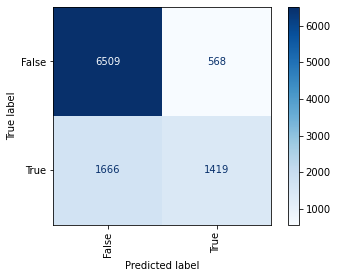

In [71]:
#Check the results
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(search, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap="Blues")

In [36]:
(11127 + 26) / len(y_val)

0.699642431466031

In [ ]:
#what is a persons average rating
#what if I only wanted 5 star books
#it is probably more interesting to do only 5 star books

Results after deleting all the star ratings: 
- True / True = 1406
- Cross-validation accuracy 0.7791362111679936

Results with all the star ratings:
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1420 / 1665

Results after deleting star ratings: 
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1419 / 1666
    - False(true) = 568
